##### Imports

In [1]:
"""
Focus on human data primarily on hIVSCC-MET for AIBS
-Tree call for Mouse
-Seurat prediction score for Human

*Make a scatter plot NMS score vs Seurat prediction score (Add n values)
1) RNA amp pass
2) RNA amp fail 


*Make same plot as Agata with barplot, tree call option with counts for RNA_amp, NMS fail and options
Collaborators have hIVSCC-MET and hIVSCC-METx
"""

'\nFocus on human data primarily on hIVSCC-MET for AIBS\n-Tree call for Mouse\n-Seurat prediction score for Human\n\n*Make a scatter plot NMS score vs Seurat prediction score (Add n values)\n1) RNA amp pass\n2) RNA amp fail \n\n\n*Make same plot as Agata with barplot, tree call option with counts for RNA_amp, NMS fail and options\nCollaborators have hIVSCC-MET and hIVSCC-METx\n'

In [2]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")

##### Start Code

In [4]:
fields_shiny = ["cell_name", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)"}

In [5]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows

INFO:functions.temp_funcs:Read file in as a pandas dataframe


In [6]:
shiny_human.rename(columns=shiny_dict, inplace=True)

In [7]:
shiny_human

,sample_id,cell_name,cDNA quality (%>400 bp),RNA amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_prediction_score_label,Tree_call
0,P1S4_190321_002_A01,H19.06.351.11.16.01.01,0.637,Pass,17.401231,hIVSCC-MET,1.303453,True,1.000000,Core
1,P1S4_190321_003_A01,H19.06.351.11.16.01.03,0.625,Pass,16.639829,hIVSCC-MET,1.182129,True,1.000000,Core
2,P2S4_171220_052_A01,H17.03.016.11.16.02,0.815,Pass,14.120809,hIVSCC-MET,1.047215,True,1.000000,Core
3,P2S4_190321_056_A01,H19.06.351.11.16.02.06,0.715,Pass,14.639516,hIVSCC-MET,0.945765,True,1.000000,Core
4,P8S4_171219_359_A01,H17.03.016.11.15.07,0.331,Pass,11.808599,hIVSCC-MET,0.777364,True,0.968926,Core
5,P8S4_171220_356_A01,H17.03.016.11.09.06,0.832,Pass,15.105618,hIVSCC-MET,0.977692,True,1.000000,Core
6,P8S4_180718_354_A01,H18.03.313.11.06.01.05,0.689,Pass,12.936141,hIVSCC-MET,1.112490,True,1.000000,Core
7,P8S4_190122_353_A01,H19.03.302.11.15.01.03,0.728,Pass,31.558592,hIVSCC-MET,0.949427,True,1.000000,Core
8,P8S4_190305_357_A01,H19.03.305.11.10.01.07,0.754,Pass,59.732915,hIVSCC-MET,0.597150,True,0.822403,PoorQ
9,P8S4_190311_351_A01,H19.03.306.11.12.01.01,0.593,Pass,15.860204,hIVSCC-MET,1.274930,True,1.000000,Core


In [8]:
shiny_human.dropna(subset=["cell_specimen_project"],inplace=True) #3578 rows

In [9]:
shiny_human.cell_specimen_project.unique()

array(['hIVSCC-MET', 'hIVSCC-METx', 'hIVSCC-METc', 'H301x', 'hMPATCH',
       'H301', 'hMPATCHseq', 'hMPATCHseqc', 'APL401Ax', 'mIVSCC-METx',
       'qIVSCC-METa', 'qIVSCC-METc'], dtype=object)

In [10]:
shinyh = filter_df(shiny_human, "cell_specimen_project", "hIVSCC-MET") #1566

INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == hIVSCC-MET


In [11]:
shinyh = create_container_df(shinyh, "sample_id")

C:\Users\kumar\Documents\GitHub\analysis_projects\analysis_scripts\functions\temp_funcs.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["collaborator_label"] = df[container_col].str[0:2]


In [12]:
shinyh.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True) #1551

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
#shinyh = shinyh[shinyh["cDNA quality (%>400 bp)"] <=1] #1504
#shinyh = shinyh[shinyh["Amplified content (ng)"] <=50] #1469

In [14]:
collaborator_dict = {"PG" : "Gabor", "PH" : "Mansvelder"}
for collab in ["P1", "P2", "P6", "P7", "P8", "P9", "PA", "PB", "PE", "PF", "PX", "P3", "P0", "P5"]:
    collaborator_dict[collab] = "AIBS"

shinyh["collaborator_label"] = shinyh["collaborator_label"].replace(collaborator_dict)

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
shinyh["collaborator_label"].unique()

array(['AIBS', 'Gabor', 'Mansvelder'], dtype=object)

In [16]:
shinyh = filter_df(shinyh, "collaborator_label", "AIBS") #1489

INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == AIBS


In [17]:
shinyh

,sample_id,cell_name,cDNA quality (%>400 bp),RNA amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_prediction_score_label,Tree_call,collaborator_label
0,P1S4_190321_002_A01,H19.06.351.11.16.01.01,0.637,Pass,17.401231,hIVSCC-MET,1.303453,True,1.000000,Core,AIBS
1,P1S4_190321_003_A01,H19.06.351.11.16.01.03,0.625,Pass,16.639829,hIVSCC-MET,1.182129,True,1.000000,Core,AIBS
2,P2S4_171220_052_A01,H17.03.016.11.16.02,0.815,Pass,14.120809,hIVSCC-MET,1.047215,True,1.000000,Core,AIBS
3,P2S4_190321_056_A01,H19.06.351.11.16.02.06,0.715,Pass,14.639516,hIVSCC-MET,0.945765,True,1.000000,Core,AIBS
4,P8S4_171219_359_A01,H17.03.016.11.15.07,0.331,Pass,11.808599,hIVSCC-MET,0.777364,True,0.968926,Core,AIBS
5,P8S4_171220_356_A01,H17.03.016.11.09.06,0.832,Pass,15.105618,hIVSCC-MET,0.977692,True,1.000000,Core,AIBS
6,P8S4_180718_354_A01,H18.03.313.11.06.01.05,0.689,Pass,12.936141,hIVSCC-MET,1.112490,True,1.000000,Core,AIBS
7,P8S4_190122_353_A01,H19.03.302.11.15.01.03,0.728,Pass,31.558592,hIVSCC-MET,0.949427,True,1.000000,Core,AIBS
8,P8S4_190305_357_A01,H19.03.305.11.10.01.07,0.754,Pass,59.732915,hIVSCC-MET,0.597150,True,0.822403,PoorQ,AIBS
9,P8S4_190311_351_A01,H19.03.306.11.12.01.01,0.593,Pass,15.860204,hIVSCC-MET,1.274930,True,1.000000,Core,AIBS


In [18]:
shinyh_rpass = filter_df(shinyh, "RNA amp Pass/Fail", "Pass") #1246
shinyh_rfail = filter_df(shinyh, "RNA amp Pass/Fail", "Fail") #243

INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail


In [19]:
colors={"Pass": "#41ab5d", "Fail": "#ef3b2c"}

Text(0.5,0,'Seurat Prediction Score')

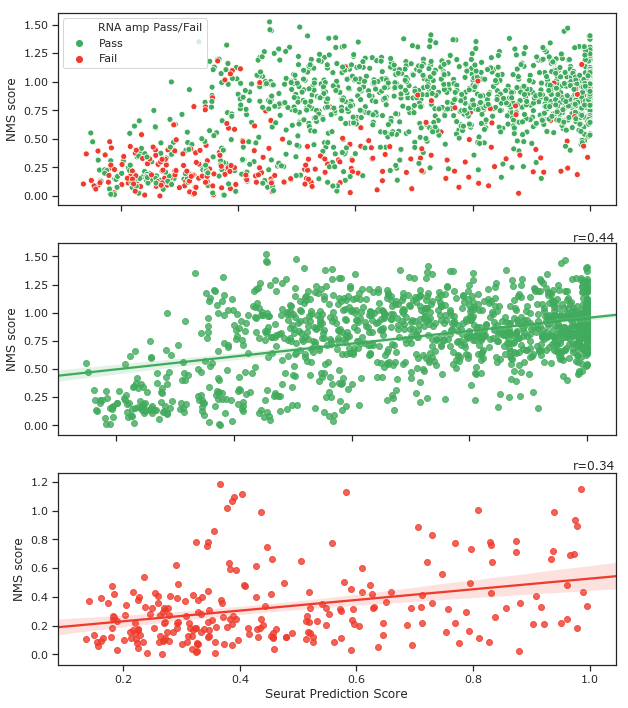

In [45]:
fig_dims = (10, 12)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="seurat_prediction_score_label", data=shinyh,
                     palette=colors, hue="RNA amp Pass/Fail", ax=axes[0])

corr = pearsonr(shinyh_rpass["seurat_prediction_score_label"], shinyh_rpass["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax1 = sns.regplot(y="NMS score", x="seurat_prediction_score_label", data=shinyh_rpass, color="#41ab5d", ax=axes[1])
ax.text(0.97, -0.4, text, fontsize=12)


corr = pearsonr(shinyh_rfail["seurat_prediction_score_label"], shinyh_rfail["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax2 = sns.regplot(y="NMS score", x="seurat_prediction_score_label", data=shinyh_rfail, color="#ef3b2c", ax=axes[2])
ax.text(0.97, -2.4, text, fontsize=12)


ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Seurat Prediction Score")

In [23]:
"RNA amp Pass/NMS Pass", "RNA amp Pass/NMS Fail", "RNA amp Fail/NMS Pass", "RNA amp Fail/NMS Fail"

('RNA amp Pass/NMS Pass',
 'RNA amp Pass/NMS Fail',
 'RNA amp Fail/NMS Pass',
 'RNA amp Fail/NMS Fail')

In [47]:
print(f"Rpass total count: {shinyh_rpass.sample_id.count()}")
print(f"Rfail total count: {shinyh_rfail.sample_id.count()}")

Rpass total count: 1246
Rfail total count: 243


##### Filter project code

In [24]:
#shinyh = filter_df(shinyh, "NMS Pass/Fail", True)
#shinyh = filter_df(shinyh, "RNA amp Pass/Fail", "Fail")

##### Counts

In [25]:
aibs = filter_df(shinyh, "collaborator_label", "AIBS")
pg = filter_df(shinyh, "collaborator_label", "Gabor")
ph = filter_df(shinyh, "collaborator_label", "Mansvelder")
print(f"Human total count: {shinyh.sample_id.count()}")
print(f"AIBS count: {aibs.sample_id.count()}")
print(f"Gabor count: {pg.sample_id.count()}")
print(f"Mansvelder count: {ph.sample_id.count()}")

INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == AIBS
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Gabor
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Mansvelder


Human total count: 1489
AIBS count: 1489
Gabor count: 0
Mansvelder count: 0
